# 1. Support Vector Machines
- Linear and Nonlinear classification, regression, and even outlier detection. SVMs are particularly well suited for classification of complex small or medium sized datasets.

Two classes can clearly be separated easily with the straight line.

- large margin classification: the largest distance between two classes from the support vectors.
- support vectors: the instance located on the edge of the class's boundary.

SVMs are sensitive to the feature scales.

## 1.1. Soft Margin Classification
Hard Margin classification: only work for data is linearly separable.

Hyperparameter C in SVM model (sklearn tool). Margin violations are bad (usually have few of them). If the SVM model is overfitting, we can try regularizing it by reducing C.

In [1]:
from sklearn import datasets
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]  # petal length, petal width
y = (iris['target'] == 2).astype(np.float64)

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42)),
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [2]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

The LinearSVC class regularizes the bias term, so you should center the training set first by subtracting its mean. This is automatic if you scale the data using the StandardScaler . Also make sure you set the loss hyperparameter to "hinge" , as it is not the default value. Finally, for better performance, you should set the dual hyperparameter to False , unless there are more features than training instances

## 1.2. NonLinear SVM Classification
Many datasets are not even close to being linearly separable.

If we plot data with second feature $x_2 = (x_1)^2$, the resulting 2D dataset is perfectly linearly separable.

In [3]:
## using PolynomialFeature transformer
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42)),
])

polynomial_svm_clf.fit(X, y)

/home/chuongnet/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

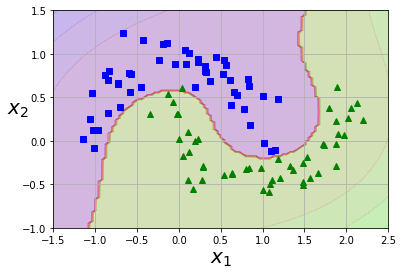

In [4]:
import matplotlib.pyplot as plt

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

### 1.2.1. Polynomial Kernel
In SVMs, the **kernel trick** math technique helps to add many polynomial features that will get the same result, even very high-degree polynomials. This trick doesn't actually add any features.

The training with SVM classifier uses a third-degree polynomial kernel, and 10th-degree polynomial kernel. If the model is overfitting, we just reduce the polynomial degree. If underfitting, just increase it. The hyperparameter coef0 controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.
- A common approach to finding the right hyperparameter values is to use grid search (see Chapter 2). It is often faster to first do a very coarse grid search, then a finer grid search around the best values found. Having a good sense of what each hyperparameter actually does can also help you search in the right part of the hyperparameter space.

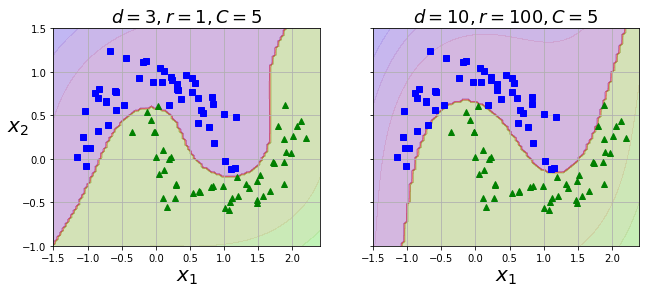

In [5]:
from sklearn.svm import SVC

# SVC provides seting up hyperparameters
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])

poly_kernel_svm_clf.fit(X, y)

# process with different degree and coef0=100
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

# plot examples with different degrees
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

### 1.2.2. Similarity features
Another technique to tackle nonlinear problems is to add features computed using a similarity function, which measures how much each instance resembles a particular landmark. For example, let’s take the 1D dataset discussed earlier and add two landmarks to it at x 1 = –2 and x 1 = 1. Next, let’s define the similarity function to be the Gaussian Radial Basis Function (RBF) with γ = 0.3 (see Equation 5-1).

- Equation 5-1. Gaussian RBF: 
$\displaystyle{\phi_{\gamma}(x, \ell) = \exp (-\gamma \parallel x - \ell \parallel^2)}$

This is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark).

You may wonder how to select the landmarks. The simplest approach is to create a landmark at the location of each and every instance in the dataset. Doing that creates many dimensions and thus increases the chances that the transformed training set will be linearly separable. The downside is that a training set with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

### 1.2.3. Gaussian RBF Kernel
This model is represented at the bottom left in Figure 5-9. The other plots show models trained with different values of hyperparameters gamma (γ) and C . Increasing gammamakes the bell-shaped curve narrower (see the lefthand plots in Figure 5-8). As a result, each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small gamma value makes the bell-shaped curve wider: instances have a larger range of influence, and the decision boundary ends up smoother. So γ acts like a regularization hyperparameter: if your model is overfitting, you should reduce it; if it is underfitting, you should increase it (similar to the C hyperparameter).

In [6]:
## using Gaussian RBF kernel
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

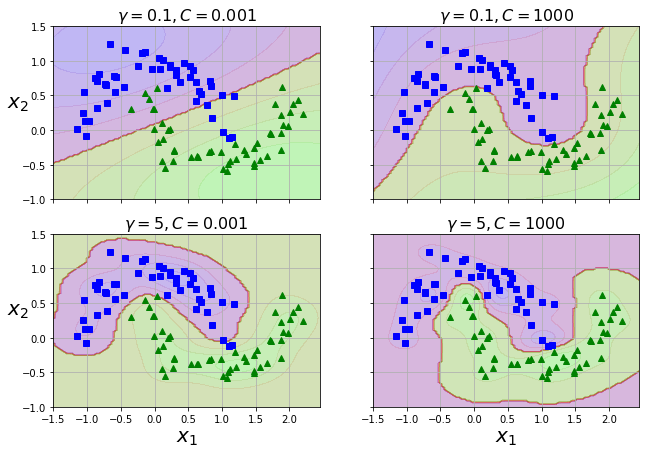

In [7]:
## examples of different gamma and C
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

## 1.3. SVM Regression
To use SVMs for regression instead of classification, the trick is to reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter, ϵ (epsilon)

To tackle nonlinear regression tasks, you can use a kernelized SVM model. SVM Regression on a random quadratic training set, using a second-degree polynomial kernel. There is little regularization in the left plot (i.e., a large C value), and much more regularization in the right plot (i.e., a small C value).

The SVR class is the regression equivalent of the SVC class, and the LinearSVR class is the regression equivalent of the LinearSVC class. The LinearSVR class scales linearly with the size of the training set (just like the LinearSVC class), while the SVR class gets much too slow when the training set grows large (just like the SVC class).

In [8]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [9]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])
eps_y_pred

array([6.52640746])

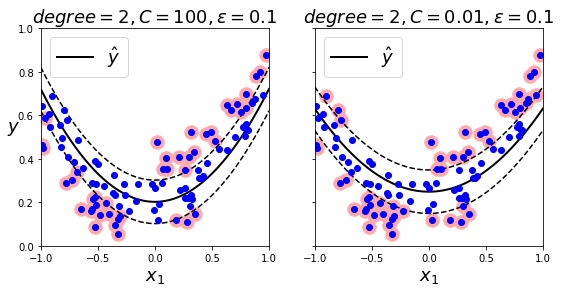

In [13]:
# polynomial SVM
from sklearn.svm import SVR


def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

    
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

# using second-degree polynomial kernel, different C
svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

# plot
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

### 1.3.1. how SVMs make predictions and how their training algorithms work
The linear SVM classifier model predicts the class of a new instance x by simply computing the decision function w ⊺ x + b = w 1 x 1 + ⋯ + w n x n + b. If the result is positive, the predicted class ŷ is the positive class (1), and otherwise it is the negative class (0).

The decision boundary (hyperplane) is the set of points where the decision function is equal to 0, and the Margin of the decision boundary where the decision function is equal to 1 and -1. The training of linear SVM classifier means finding the values of w and b that make this margin as wide as possible while avoiding margin violations (hard margin), or limiting them (soft margin).

### 1.3.2. Kernelized SVMs
Applying a second-degree polynomial transformation to a two-dimensional training set, then train a linear SVM classifier on the transformed training set. In SVMs, there are many of Kernel trick transformations ($\phi$) to all training instances.

- Common kernels
     1. Linear: $K(a,b) = a^Tb$
     2. Polynomial: $K(a,b) = (\gamma a^Tb + r)^d$, second-degree polynomial when r=0, d=2 and gamma
     3. Gaussian RBF: $K(a,b) = \exp \left(-\gamma \parallel a -b \parallel^2\right)$
     4. Sigmoid: $K(a,b) = \tanh \left( \gamma a^Tb + r \right)$
     
